In [2]:
from zipfile import ZipFile

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with ZipFile('/content/drive/MyDrive/Tuberculosis_Split_Data/TB_Split_Data.zip') as zipobj:
  zipobj.extractall('/content/MyDrive/Tuberculosis_Split_Data/TB_Split_Data_NEW')

In [10]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/MyDrive/Tuberculosis_Split_Data/TB_Split_Data_NEW/TB_Split_Data/train'
test_path = '/content/MyDrive/Tuberculosis_Split_Data/TB_Split_Data_NEW/TB_Split_Data/test'
valid_path = '/content/MyDrive/Tuberculosis_Split_Data/TB_Split_Data_NEW/TB_Split_Data/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_width = 500
img_height = 500
#The dimension of the images we are going to define is 500x500 img_height = 500



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [12]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 3360 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


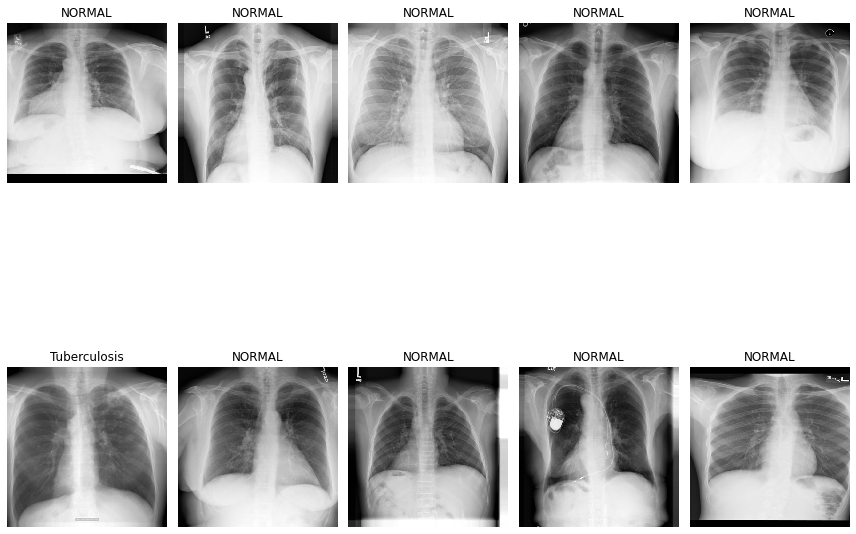

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'Tuberculosis'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [18]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [23]:
# # Hyperparameters of Conv2D
# tf.keras.layers.Conv2D(
#     filters,
#     kernel_size,
#     strides=(1, 1),
#     padding="valid",
#     activation=None,
#     input_shape=(height,width,color channel)
#     )
# # Hyperparameters of MaxPooling2D 
# MaxPooling2D(
#     pool_size=(2, 2), strides=None, padding="valid"
#     )

SyntaxError: ignored

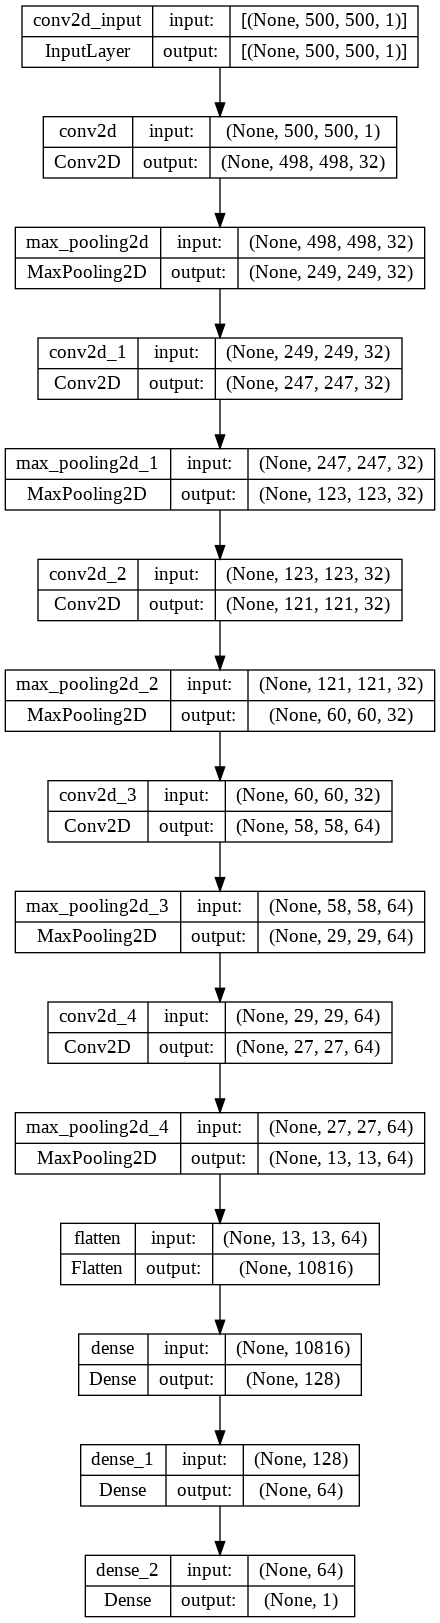

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [26]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [29]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight ='balanced',  classes = np.unique(train.classes),y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.6, 1: 3.0}


In [30]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
210/210 [==============================] - 1165s 6s/step - loss: 0.5009 - accuracy: 0.7399 - val_loss: 0.2413 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - 1124s 5s/step - loss: 0.3243 - accuracy: 0.8696 - val_loss: 0.1391 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - 1126s 5s/step - loss: 0.2782 - accuracy: 0.8872 - val_loss: 0.1664 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8854
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 1115s 5s/step - loss: 0.3346 - accuracy: 0.8854 - val_loss: 0.2793 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - 1113s 5s/step - loss: 0.2861 - accuracy: 0.8884 - val_loss: 0.1623 - val_accuracy: 0.9500 - lr: 3.0000e-04


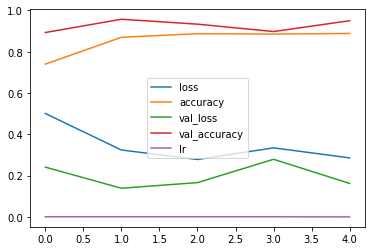

In [31]:
pd.DataFrame(cnn.history.history).plot()


In [32]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 34s 1s/step - loss: 0.1823 - accuracy: 0.9476
The testing accuracy is : 94.76190209388733 %


In [33]:
preds = cnn.predict(test,verbose=1)


27/27 [==============================] - 35s 1s/step


In [34]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

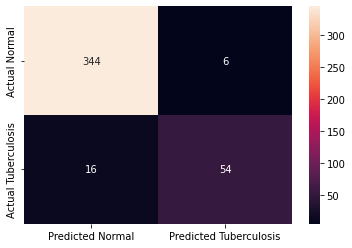

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [39]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       350
TUBERCULOSIS       0.90      0.77      0.83        70

    accuracy                           0.95       420
   macro avg       0.93      0.88      0.90       420
weighted avg       0.95      0.95      0.95       420



(420, 500, 500, 1)
(420,)


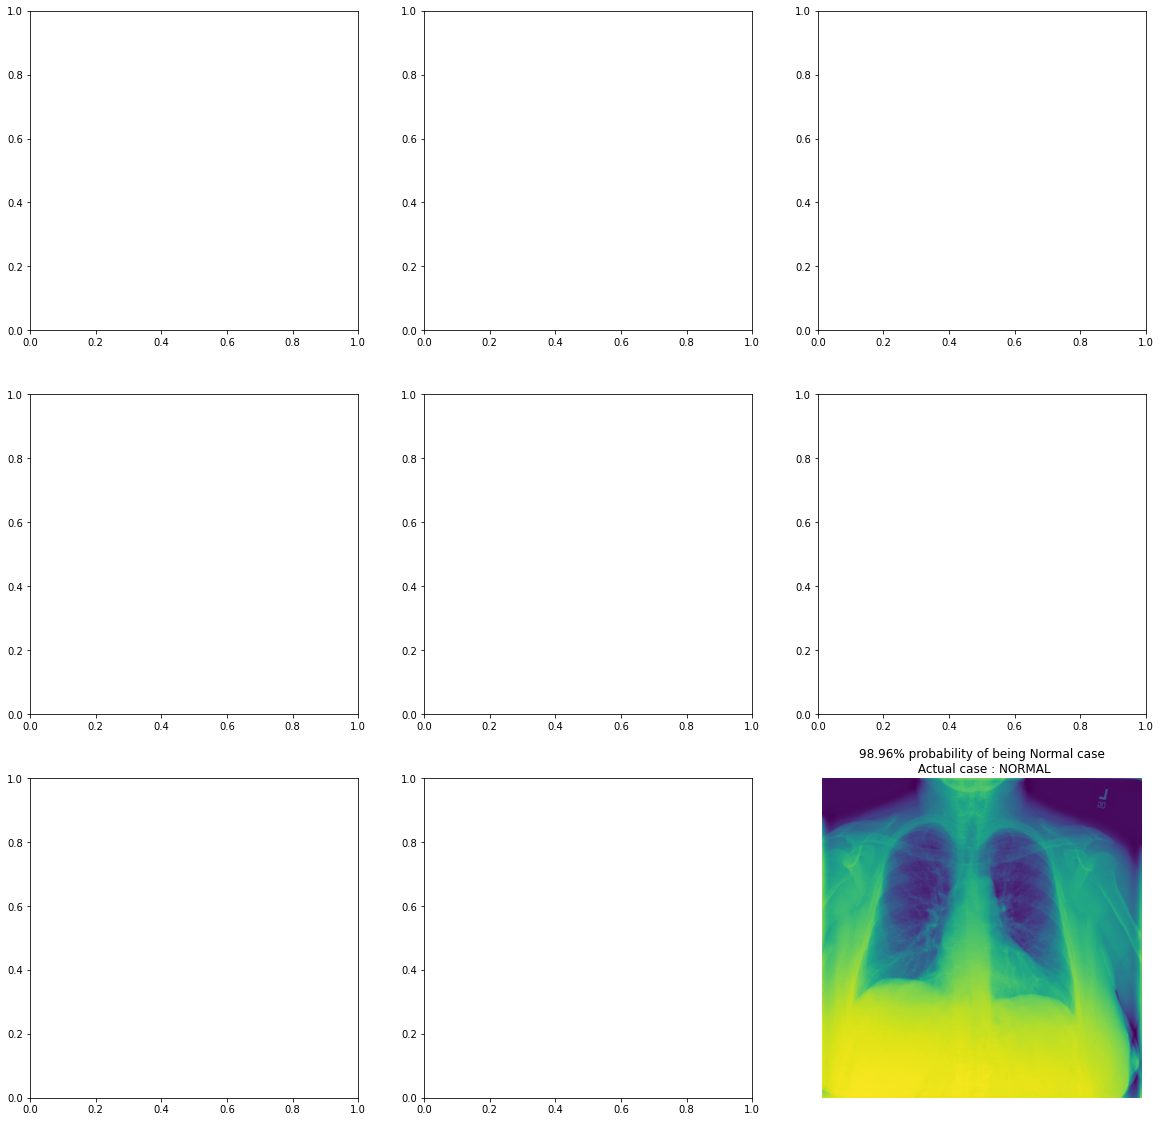

In [41]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'Tuberculosis'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 351ms/step


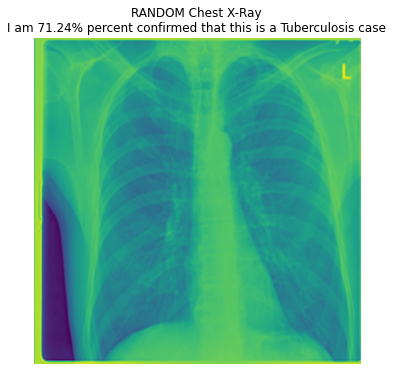

In [40]:
# Testing with my own Chest X-Ray
hardik_path = '/content/MyDrive/Tuberculosis_Split_Data/TB_Split_Data_NEW/TB_Split_Data/val/Tuberculosis/Tuberculosis-150.png'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Tuberculosis case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("RANDOM Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()